In [1]:
options(scipen = 999)  # Suppress scientific notation globally
library(tidyverse)
library(lubridate)
library(geosphere)
library(repr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


# Cyclistic Bikeshare Case Study


## Importing the CSVs into data frames


In [2]:
dt2019 <- read_csv("Divvy_Trips_2019_Q1.csv")
dt2020 <- read_csv("Divvy_Trips_2020_Q1.csv")

Rows: 365069 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): start_time, end_time, from_station_name, to_station_name, usertype,...
dbl (5): trip_id, bikeid, from_station_id, to_station_id, birthyear
num (1): tripduration

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 426887 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (5): ride_id, rideable_type, start_station_name, end_station_name, memb...
dbl  (6): start_station_id, end_station_id, start_lat, start_lng, end_lat, e...
dttm (2): started_at, ended_at

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## Cleaning 
#### `colnames()` reveals that the dataframes use different variable names for columns'

Datasets are also revealed to use different bucketing systems
-	"Customer/Subscriber"(2019), 
-	"member/casual"2010
2020 & 2019 dates are in different formats
Geospatial data missing from 2019 Data
Trip Duration Data missing from 2020 Data
A calculated distance will be useful for further analysis


In [3]:
print("IMPORTED DATAFRAMES")
colnames(dt2019)
colnames(dt2020)


[1] "IMPORTED DATAFRAMES"


[1] "trip_id"           "start_time"        "end_time"         
 [4] "bikeid"            "tripduration"      "from_station_id"  
 [7] "from_station_name" "to_station_id"     "to_station_name"  
[10] "usertype"          "gender"            "birthyear"

[1] "ride_id"            "rideable_type"      "started_at"        
 [4] "ended_at"           "start_station_name" "start_station_id"  
 [7] "end_station_name"   "end_station_id"     "start_lat"         
[10] "start_lng"          "end_lat"            "end_lng"           
[13] "member_casual"

### Renaming & Restructuring for compatibility of dataframes
Calculate: tripduration(calculate)  
Normalize the member_casual(usertype)  
Latitude & Longitude (2019 missing)  

### Rebucketing member_casual(2020)/usertype(2019), Fixing Date Formats on 2020 DF and Calcualting Trip Duration on 2020 table

In [4]:
dt19rebucket <- dt2019 %>%
	mutate(usertype=case_when(usertype=="Subscriber"~"member",TRUE ~ "casual")) 
dt2020_tripduration <- dt2020 %>%
	mutate(tripduration = ended_at-started_at,
		started_at=format(started_at,"%Y-%m-%d %H:%M:%S"),
		ended_at=format(ended_at,"%Y-%m-%d %H:%M:%S")
	)

### Renaming vars(2019) for compatibility

In [5]:
dt19RenCol <- dt19rebucket %>% rename(
	ride_id=trip_id, 
	started_at=start_time, ended_at=end_time,
	start_station_id=from_station_id,
	start_station_name=from_station_name,
	end_station_id=to_station_id, 
	end_station_name=to_station_name,
	member_casual=usertype) %>% 
	select(ride_id,started_at,ended_at,
		start_station_name,start_station_id,
		end_station_name,end_station_id,
		member_casual,tripduration)
rm(dt19rebucket) 
rm(dt2020)
rm(dt2019)

## Reconstruct missing Geospatial Information for 2019 DataFrame  

### Get all station names and locations


In [6]:
station_ids <- c(
  dt19RenCol$start_station_id,
  dt19RenCol$end_station_id,
  dt2020_tripduration$start_station_id,
  dt2020_tripduration$end_station_id
) 
station_names <- c(
  dt19RenCol$start_station_name,
  dt19RenCol$end_station_name,
  dt2020_tripduration$start_station_name,
  dt2020_tripduration$end_station_name
) 

### Generate The Station/Geospatial List of Stations

In [7]:
station_names_ids <- data.frame(station_id=station_ids,station_name=station_names) %>% 
	filter(!is.na(station_id),!is.na(station_name)) %>% distinct(station_id,.keep_all=T)
station_loc <- data.frame(
	station_id=c(dt2020_tripduration$start_station_id,
		dt2020_tripduration$end_station_id),
	lat=c(dt2020_tripduration$start_lat,
		dt2020_tripduration$end_lat),
	lng=c(dt2020_tripduration$start_lng,
		dt2020_tripduration$end_lng))%>%
        filter(!is.na(station_id),!is.na(lat),!is.na(lng)) %>% 
    distinct(station_id,.keep_all=T)
# Joining the names with the location data 
stations <- station_names_ids %>% inner_join(station_loc,by="station_id") 

### Populate the 2019 DF with Geospatial data from the STATIONS DF

In [8]:
dt19Geospatial <- dt19RenCol %>% mutate(
start_lat=stations$lat[match(start_station_id,stations$station_id)], start_lng=stations$lng[match(start_station_id,stations$station_id)],
end_lat=stations$lat[match(end_station_id,stations$station_id)],
end_lng=stations$lng[match(end_station_id,stations$station_id)]
) 

### Intersect the Common Variables

In [9]:
names2019 <- colnames(dt19Geospatial)
names2020 <- colnames(dt2020_tripduration)
common_names <- intersect(names2019, names2020)

### Concatenante the 2 dataframes

In [10]:
cyclistic <- rbind(dt19Geospatial[common_names],dt2020_tripduration[common_names])
rm(common_names)
rm(names2019)
rm(names2020)

### Calculating and adding a tripduration_minutes column

In [11]:
cyclistic_tripDurMinutes <- cyclistic %>% mutate(trip_duration_minutes=tripduration/60)
cyclistic <- cyclistic_tripDurMinutes
rm(cyclistic_tripDurMinutes)

### Calculate the distances using the haversine formula

In [12]:
cyclistic_haversine <- cyclistic %>% mutate(distance=distHaversine(cbind(start_lng,start_lat),cbind(end_lng,end_lat)))
cyclistic <- cyclistic_haversine
rm(cyclistic_haversine)

### Calculate the Speed of the trip

In [13]:
cyclistic_speed <- cyclistic %>% mutate(speed_kmh = (distance/1000)/(tripduration/3600))
cyclistic <- cyclistic_speed
#rm(cyclistic_speed)

### Remove Station 675
675 is the HQ & Warehouse, this data represents a Repair & Operations hub and should be filtered out.


In [14]:
cyclistic_675 <- cyclistic %>% filter(start_station_id!=675) %>% head(n=nrow(.))
cyclistic <- cyclistic_675
rm(cyclistic_675)

### Removing Outliers
By creating a new column with `duration_hours_limit` represented as minutes
Some of the trips were several days long and even months
remove anything longer than `duration_hours_limit` days


In [15]:
# Mutate tripduration(seconds) into HOURS
duration_hours_limit <-  2 
cyclistic_filtered_outliers <- cyclistic %>%
  mutate( trip_duration_hours = trip_duration_minutes / 60 ) %>%
  filter(trip_duration_hours < duration_hours_limit)
cyclistic <- cyclistic_filtered_outliers
rm(cyclistic_filtered_outliers)

### Descriptive Analysis

In [16]:
# Mode function
get_mode <- function(x) {
  uniq_vals <- unique(x)
  uniq_vals[which.max(tabulate(match(x, uniq_vals)))]
}
colnames(cyclistic)
head(cyclistic)
str(cyclistic)
## General Shape of the data 
range(cyclistic$started_at)
range(cyclistic$start_station_id)
## Trip Durations
cyclistic%>%summarize(min=min(trip_duration_minutes),max=max(trip_duration_minutes),average=mean(trip_duration_minutes,na.rm=TRUE))

## Trip Distances
cyclistic%>%summarize(min=min(distance,na.rm=T),max=max(distance,na.rm=T),average=mean(distance,na.rm=TRUE))

# Weekday Mode (weekday with most rides)
get_mode(lubridate::wday(cyclistic$started_at,label=T))

[1] "ride_id"               "started_at"            "ended_at"             
 [4] "start_station_name"    "start_station_id"      "end_station_name"     
 [7] "end_station_id"        "member_casual"         "tripduration"         
[10] "start_lat"             "start_lng"             "end_lat"              
[13] "end_lng"               "trip_duration_minutes" "distance"             
[16] "speed_kmh"             "trip_duration_hours"

ride_id,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,member_casual,tripduration,start_lat,start_lng,end_lat,end_lng,trip_duration_minutes,distance,speed_kmh,trip_duration_hours
<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
21742443,2019-01-01 0:04:37,2019-01-01 0:11:07,Wabash Ave & Grand Ave,199,Milwaukee Ave & Grand Ave,84,member,390,41.8915,-87.6268,41.8916,-87.6484,6.500000,1789.9693,16.522793,0.1083333
21742444,2019-01-01 0:08:13,2019-01-01 0:15:34,State St & Randolph St,44,Dearborn St & Van Buren St (*),624,member,441,41.8847,-87.6277,41.8763,-87.6292,7.350000,943.3121,7.700507,0.1225000
21742445,2019-01-01 0:13:23,2019-01-01 0:27:12,Racine Ave & 18th St,15,Western Ave & Fillmore St (*),644,member,829,41.8582,-87.6565,41.8686,-87.6862,13.816667,2720.8399,11.815469,0.2302778
21742446,2019-01-01 0:13:45,2019-01-01 0:43:28,California Ave & Milwaukee Ave,123,Clark St & Elm St,176,member,1783,41.9227,-87.6972,41.9030,-87.6313,29.716667,5883.1449,11.878475,0.4952778
21742447,2019-01-01 0:14:52,2019-01-01 0:20:56,Mies van der Rohe Way & Chicago Ave,173,Streeter Dr & Grand Ave,35,member,364,41.8969,-87.6217,41.8923,-87.6120,6.066667,953.0317,9.425588,0.1011111
21742448,2019-01-01 0:15:33,2019-01-01 0:19:09,LaSalle St & Washington St,98,Dearborn St & Monroe St,49,member,216,41.8827,-87.6325,41.8813,-87.6295,3.600000,293.4448,4.890746,0.0600000


tibble [784,286 × 17] (S3: tbl_df/tbl/data.frame)
 $ ride_id              : chr [1:784286] "21742443" "21742444" "21742445" "21742446" ...
 $ started_at           : chr [1:784286] "2019-01-01 0:04:37" "2019-01-01 0:08:13" "2019-01-01 0:13:23" "2019-01-01 0:13:45" ...
 $ ended_at             : chr [1:784286] "2019-01-01 0:11:07" "2019-01-01 0:15:34" "2019-01-01 0:27:12" "2019-01-01 0:43:28" ...
 $ start_station_name   : chr [1:784286] "Wabash Ave & Grand Ave" "State St & Randolph St" "Racine Ave & 18th St" "California Ave & Milwaukee Ave" ...
 $ start_station_id     : num [1:784286] 199 44 15 123 173 98 98 211 150 268 ...
 $ end_station_name     : chr [1:784286] "Milwaukee Ave & Grand Ave" "Dearborn St & Van Buren St (*)" "Western Ave & Fillmore St (*)" "Clark St & Elm St" ...
 $ end_station_id       : num [1:784286] 84 624 644 176 35 49 49 142 148 141 ...
 $ member_casual        : chr [1:784286] "member" "member" "member" "member" ...
 $ tripduration         : num [1:784286] 390 441 82

[1] "2019-01-01 0:04:37"  "2020-03-31 23:51:34"

[1]   2 673

min,max,average
<dbl>,<dbl>,<dbl>
0.01666667,119.9833,12.35786


min,max,average
<dbl>,<dbl>,<dbl>
0,21792.88,1835.777


[1] Tue
Levels: Sun < Mon < Tue < Wed < Thu < Fri < Sat

### Ride Averages per user type 

In [17]:
cyclistic %>% group_by(member_casual) %>% summarize(average=mean(tripduration,na.rm=T),min=min(tripduration),max=max(tripduration),mode=get_mode(tripduration))

member_casual,average,min,max,mode
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
casual,1705.6966,2,7199,603
member,654.3898,1,7195,313


## EXPLORATION
Question: How do members use the service differently than casual users
- Time of day
- trip_duration vs distance?
- weekdays/weekends

### Plot Trip durations vs trip distances
Here we see that there is an overlap in the "leisuriness/rushyness" of the trips taken by members as well as casual users, suggesting that many casual users are using the service to commute. A higher slope angle represents a more leisurely pace while a lower slope angle suggests a more rushed pace. The samples which form a straight vertical line represent trips which ended in the same station that they startedin, suggesting a completely leisurely ride with the highest ones taking the longest.


In [18]:
# Set plot sizes
options(repr.plot.width = 12, repr.plot.height = 10)

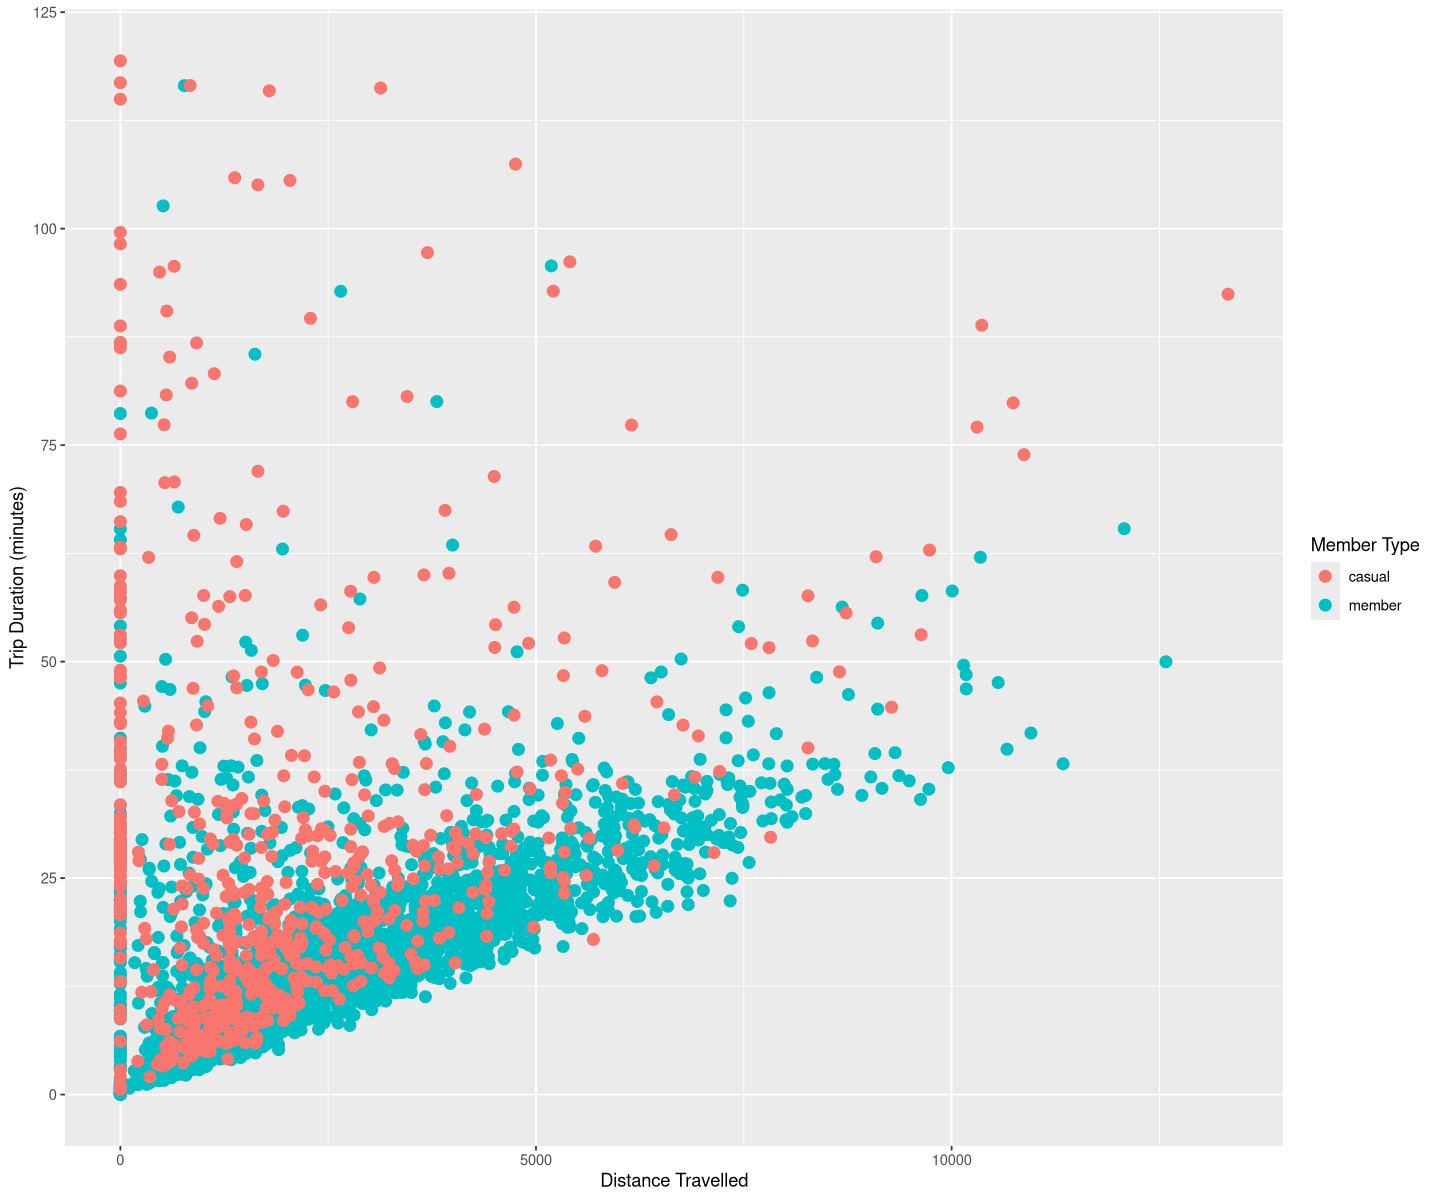

In [19]:
 cyclistic[sample(nrow(cyclistic),size=7800),] %>%
	arrange(desc(member_casual))%>%  #Z plot order control
	ggplot(aes(x=distance,y=trip_duration_minutes,color=member_casual))+
	geom_point(size=3)+labs(x="Distance Travelled",y="Trip Duration (minutes)",color="Member Type")

### Plot top destination station with the most rushed users
Here we see the destinations with the least lesurly trips(highest speed) and largest number of trips, suggesting a commute destination. These are the best stations to target commuters on the casual tiers.

`summarise()` has grouped output by 'end_station_id', 'end_station_name'. You
can override using the `.groups` argument.


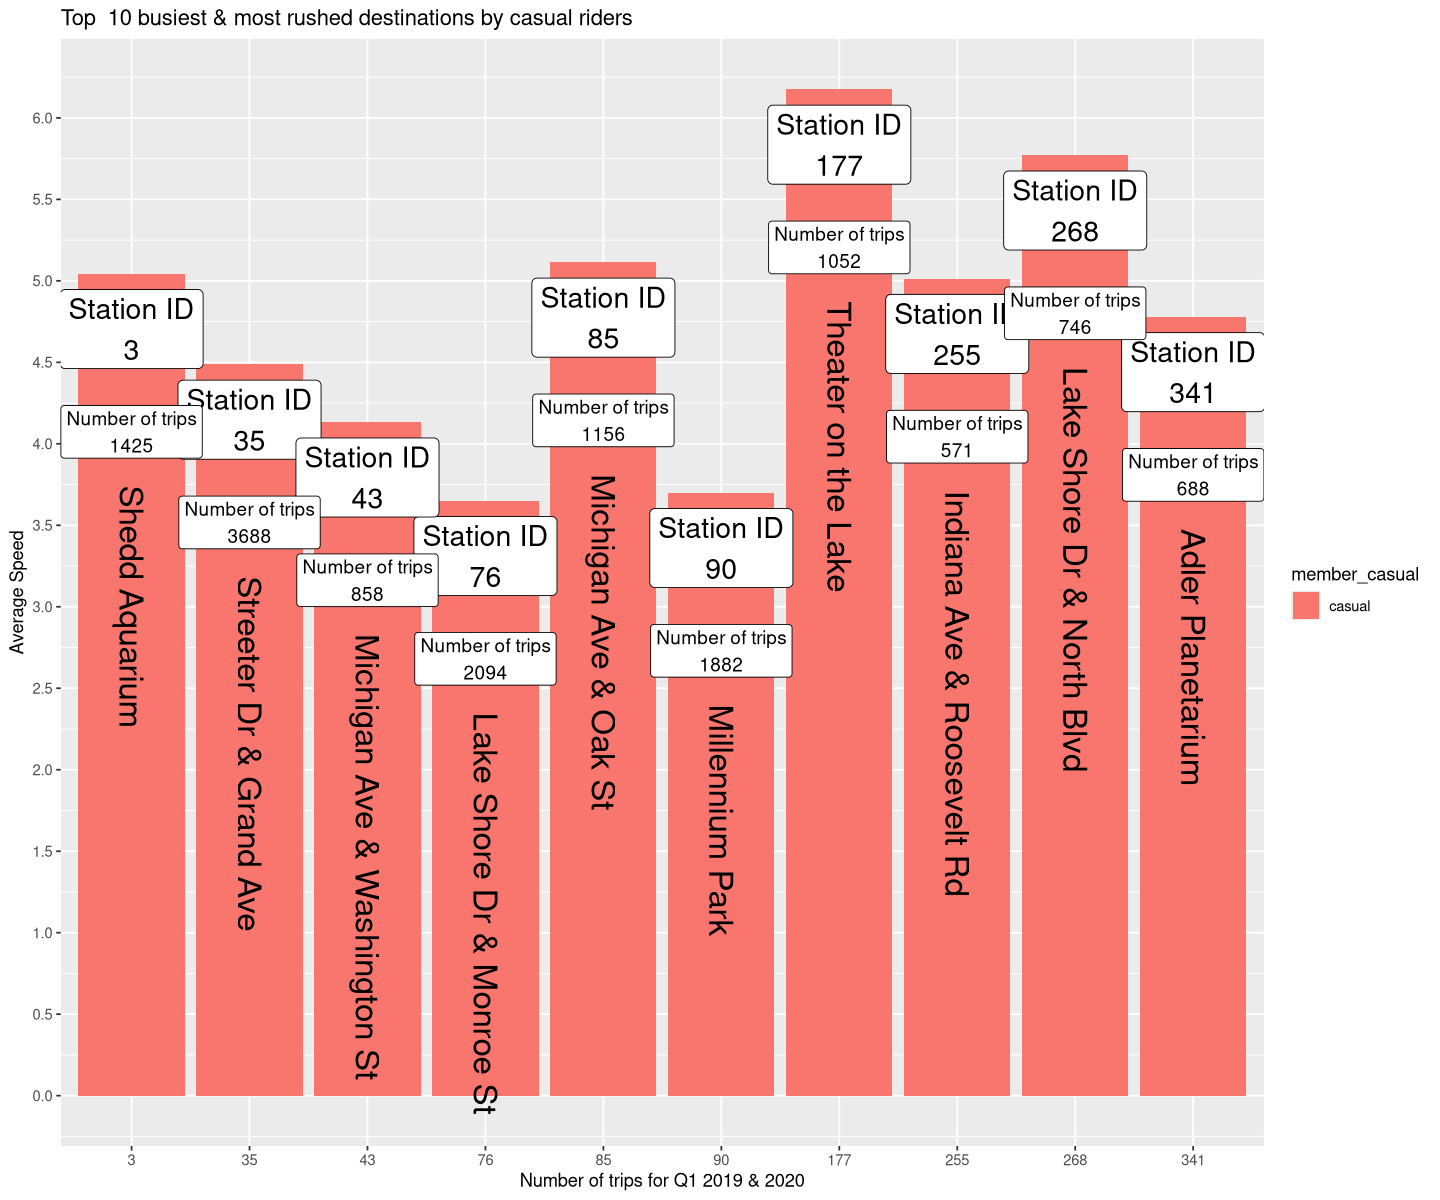

In [20]:
topn<-10
cyclistic %>%
  group_by(end_station_id,end_station_name,member_casual) %>%
  summarize(avgSpeed = mean(speed_kmh),tripcount=n()) %>%
  arrange(desc(tripcount),desc(avgSpeed))%>%
	filter(member_casual=="casual")%>%
	head(n=topn)%>%
  ggplot(aes(x = factor(end_station_id), y = avgSpeed,fill=member_casual)) +
  geom_col() +
  geom_text(aes(label=end_station_name,y=avgSpeed-1.3),hjust=0,size=7,angle=-90)+
  geom_label(aes(label=paste0("Station ID\n",end_station_id)),fill="white",vjust=1.2,size=6)+
  geom_label(aes(label=paste0("Number of trips\n",tripcount)),fill="white",vjust=3.5,size=4)+
  scale_y_continuous(n.breaks = 12)+
  labs(title=paste("Top ",topn,"busiest & most rushed destinations by casual riders"),y="Average Speed",x="Number of trips for Q1 2019 & 2020")

### Usage by Hour
Here we see that member usage increases at rush hours times suggesting that members generally use the service for daily work commuting.
Also we can see that casual users have a more regular bell-curve distribution centered at around 3pm

The most frequently occuring trips overall are to and from station 192 which is the Adams & canal station, right next to chicago union station this suggests that most trips are part of a daily commute

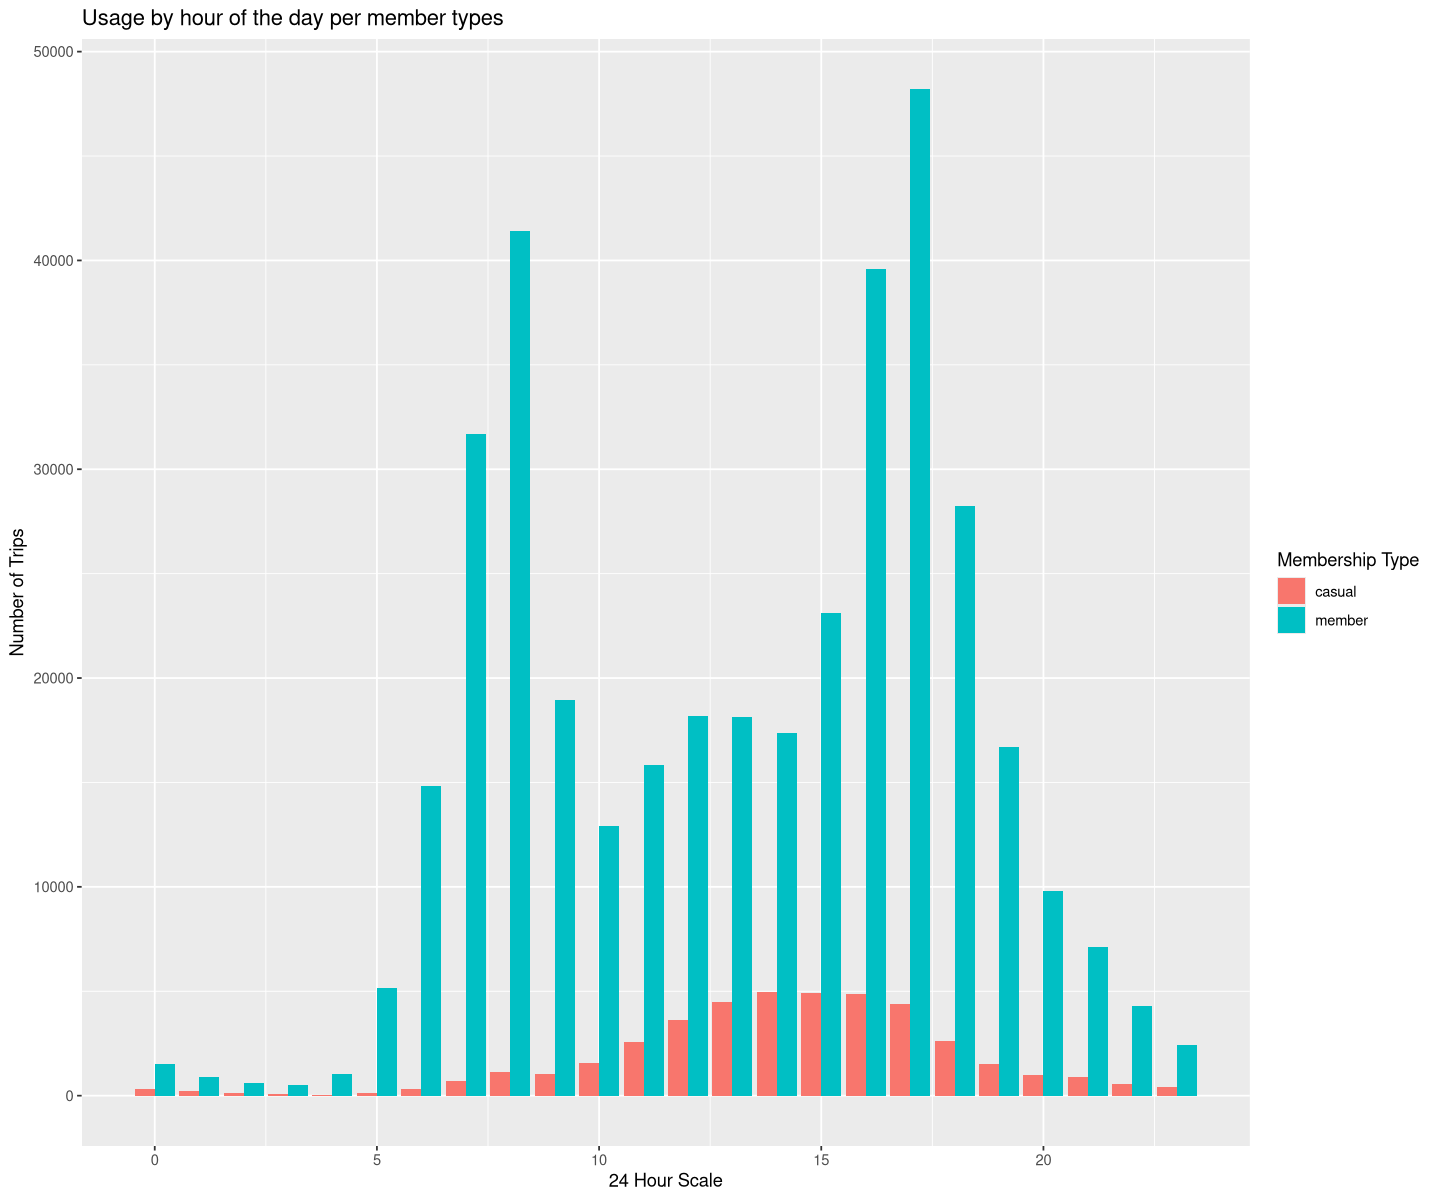

In [21]:
cyclistic %>% 
  mutate(hour = lubridate::hour(started_at)) %>%
  mutate(year = lubridate::year(started_at)) %>%
  # Count by user type and hour
  count(member_casual, hour,year) %>% 
  # Create the plot AFTER all data manipulation
  ggplot(aes(x = hour, y = n, fill = member_casual)) +
  geom_col(position = "dodge")+labs(fill="Membership Type")+
  labs(title="Usage by hour of the day per member types",
	x="24 Hour Scale",y="Number of Trips")

### Usage by weekday
When usage is measured by weekday we can see that members tend for heavier use during the weekdays and tapering off on the weekends, while casual users are seeing an increase during the weekends, with the highest usage on Sundays.
Suggest that weekend discounts for members might attract more of the weekend casual riders to a membership.


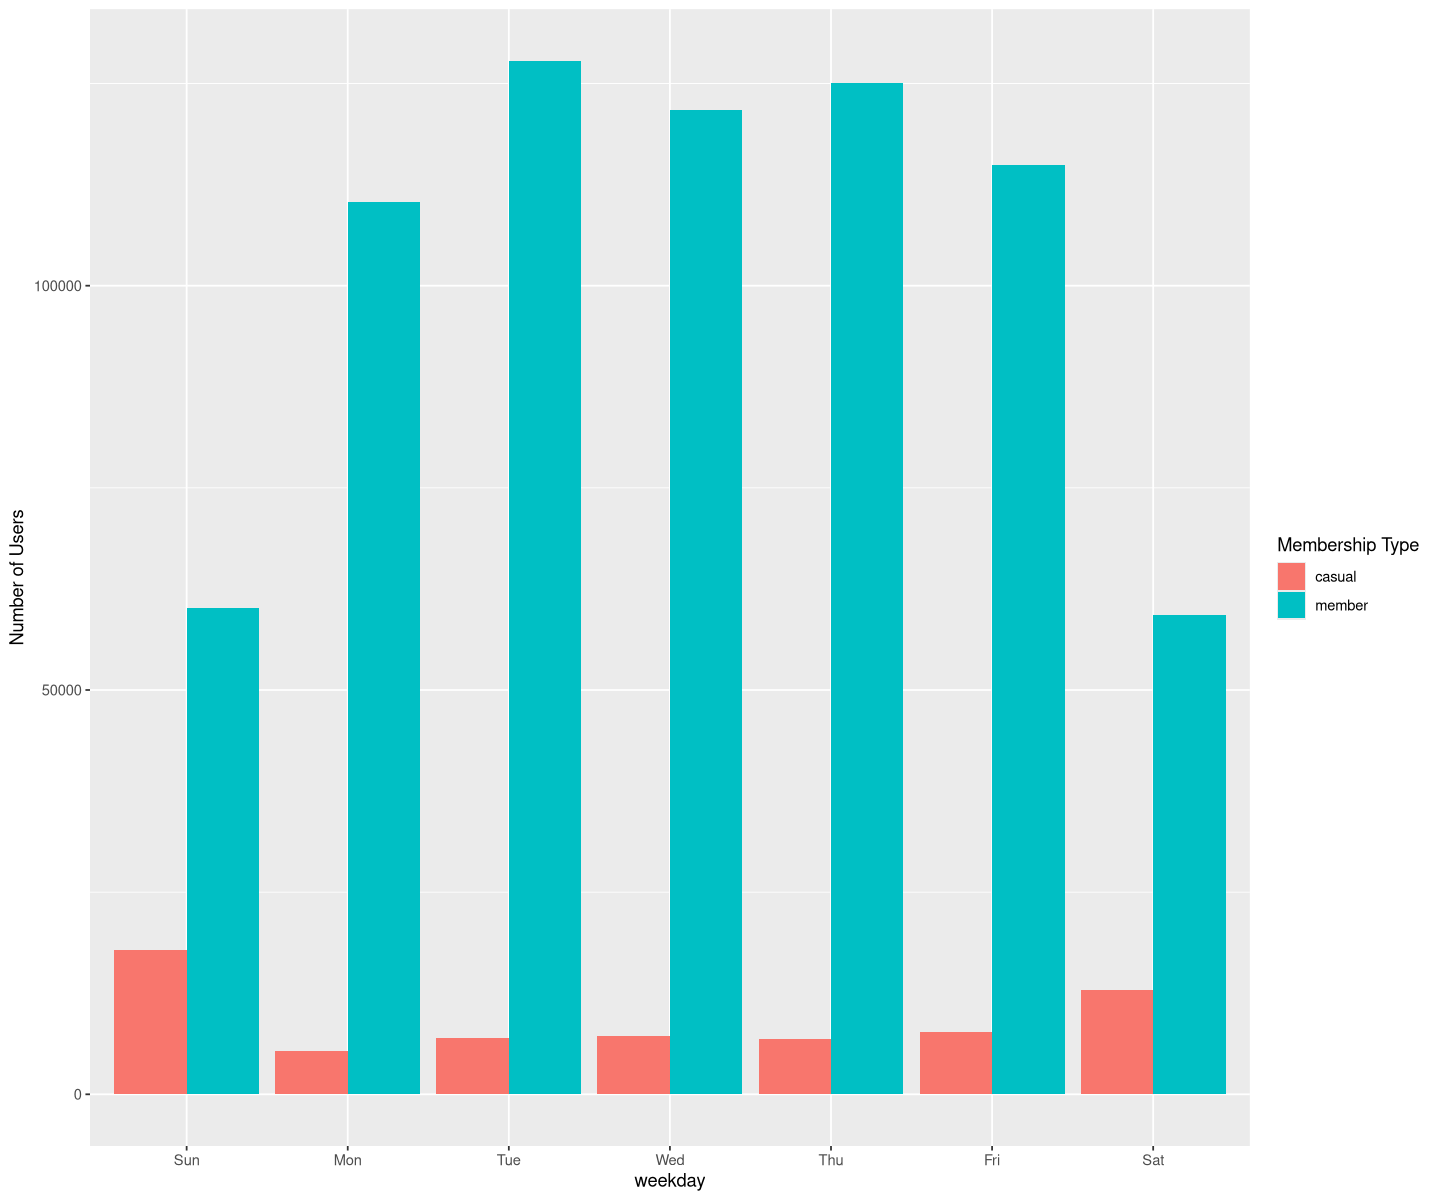

In [22]:
cyclistic %>% 
  mutate(weekday = lubridate::wday(started_at,label=T)) %>%
  # Count by user type and hour
  count(member_casual, weekday) %>% 
  # Create the plot AFTER all data manipulation
  ggplot(aes(x = weekday, y = n, fill = member_casual)) +
  geom_col(position = "dodge")+labs(fill="Membership Type",y="Number of Users")+
	scale_y_continuous(labels = function(x) format(x, scientific = FALSE))